# load libraries and data

In [101]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
from sklearn.model_selection import ParameterGrid, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from MYdata_methods import fill_and_upsample
from collections import OrderedDict

In [2]:
df_full = pd.read_csv("data.csv", header=None, index_col = 0, names=["id","clumpthick","cellsize_uniformity","cellshape_uniformity","adhesion","epi_cellsize","nuclei","chromatin","nucleoli","mitoses","class"])
df_full.head(5)

,clumpthick,cellsize_uniformity,cellshape_uniformity,adhesion,epi_cellsize,nuclei,chromatin,nucleoli,mitoses,class
id,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


# EDA

In [3]:
# num missing vals
tot_count = df_full.shape[0]
for col in df_full.columns:
    print (col, tot_count - df_full[col].count())

clumpthick 0
cellsize_uniformity 0
cellshape_uniformity 0
adhesion 0
epi_cellsize 0
nuclei 0
chromatin 0
nucleoli 0
mitoses 0
class 0


/Users/dgrayson1/anaconda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


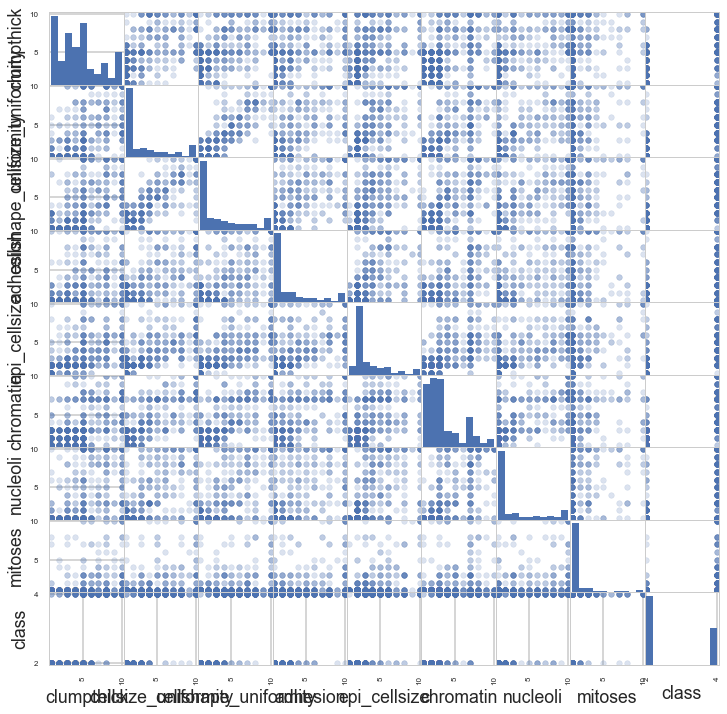

In [4]:
fig, ax = plt.subplots(figsize=(12, 12))
scatter_matrix(df_full, alpha=0.2, ax=ax);
plt.show()

# reshape predictors and outcome, convert all to numeric and recheck missing values

In [5]:
outcome = df_full['class']
df = df_full.copy()
df = df.drop('class',axis=1)
df.nuclei = pd.to_numeric(df.nuclei, errors='coerce')
df_full.head(5)

,clumpthick,cellsize_uniformity,cellshape_uniformity,adhesion,epi_cellsize,nuclei,chromatin,nucleoli,mitoses,class
id,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [6]:
# num missing outcome vals
tot_count = df.shape[0]
print ("outcome", tot_count - outcome.count())

outcome 0


In [7]:
# num missing predictor vals
for col in df.columns:
    print (col, tot_count - df[col].count())

clumpthick 0
cellsize_uniformity 0
cellshape_uniformity 0
adhesion 0
epi_cellsize 0
nuclei 16
chromatin 0
nucleoli 0
mitoses 0


In [117]:
# show t-tests on each predictor
b = df[outcome == 2]
m = df[outcome == 4]
tstat_dict={}
for col in df.columns:
    tstat, pval = sp.stats.ttest_ind(m[col],b[col],equal_var = False, nan_policy = 'omit')
    #print (col, tstat)
    tstat_dict[col] = tstat
    
tstats = pd.DataFrame.from_dict(tstat_dict, orient='index')
print (tstats)

                              0
clumpthick            24.231253
cellsize_uniformity   29.112678
cellshape_uniformity  29.837096
adhesion              19.732960
epi_cellsize          19.425565
nuclei                30.021759
chromatin             25.036467
nucleoli              20.650284
mitoses                9.168234


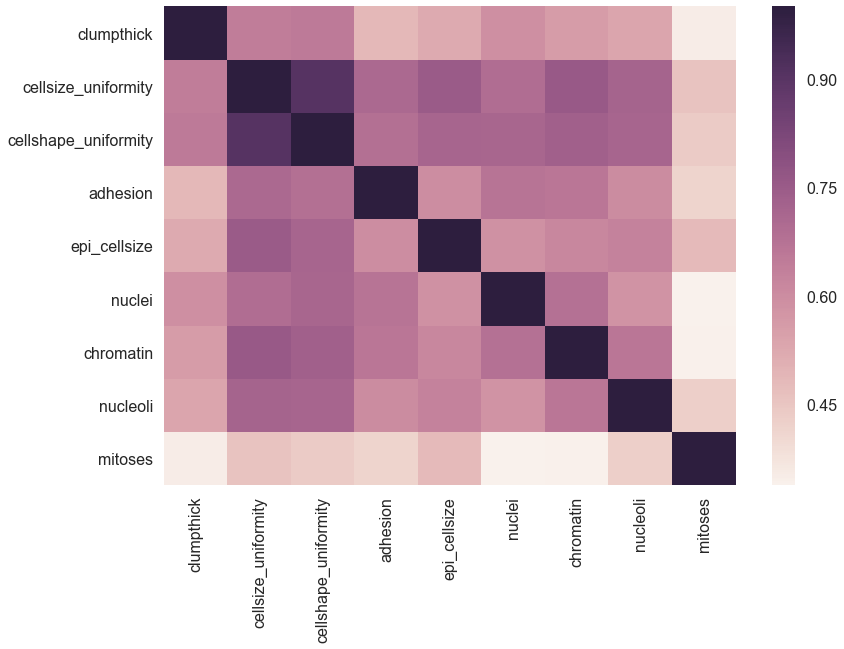

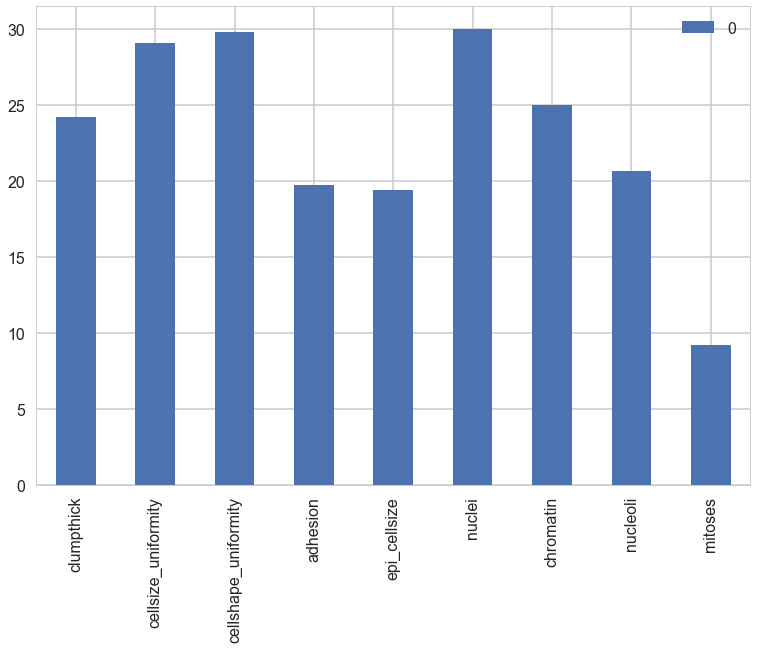

In [118]:
# show correlations among predictors
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
tstats.plot(kind='bar')
plt.show()

# make new dataframes with missing data imputed, can try SMOTING too

In [54]:
df_resamp, outcome_resamp = fill_and_upsample(df, outcome, 'KNN', False)
#df_impute, outcome_impute = fill_and_upsample(df, outcome, 'KNN', False)

In [ ]:
def MY_train_test_split(signals, labels, test_size_percent):
    
    train_signals_raw, test_signals_raw, train_labels_raw, test_labels_raw = train_test_split(signals, labels, test_size=test_size_percent)

# model 1: random forest

In [72]:
#gridsearch first using oob error
param_grid = {
    'max_features': ['auto', 0.5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
}

rf = RandomForestClassifier(n_estimators=450, oob_score=True)

best_score = 0
for g in ParameterGrid(param_grid):
    rf.set_params(**g)
    rf.fit(df_resamp, outcome_resamp)
    if rf.oob_score_ > best_score:
        best_score = rf.oob_score_
        best_grid = g

print ("OOB: %0.5f" % best_score)
print ("Grid:", best_grid)

OOB: 0.97282
Grid: {'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}


In [73]:
#gridsearch w/ CV error
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 10)
CV_rfc.fit(df_resamp, outcome_resamp)
print ("CV score:", CV_rfc.best_score_)
print ("Grid:", CV_rfc.best_params_)

CV score: 0.969957081545
Grid: {'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}


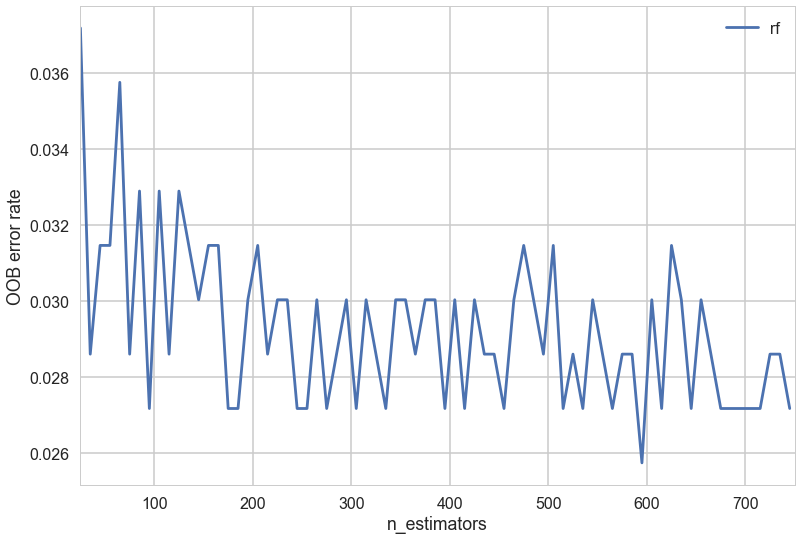

In [74]:
error_rate = {'rf' : []}
min_estimators = 25
max_estimators = 750
interval_estimators = 10
for i in range(min_estimators, max_estimators + 1,interval_estimators):
    rf.set_params(n_estimators=i)
    rf.set_params(**best_grid)
    rf.fit(df_resamp, outcome_resamp)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    error_rate['rf'].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

# plot feature importances

In [126]:
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=df_resamp.columns, columns=["Importance"])
importance = importance.sort_values(by="Importance", ascending = False)
importance

,Importance
cellsize_uniformity,0.277978
cellshape_uniformity,0.236771
nuclei,0.170804
chromatin,0.115383
epi_cellsize,0.065194
nucleoli,0.059255
clumpthick,0.045650
adhesion,0.023046
mitoses,0.005919


# model 2: GBM

In [78]:
score = cross_val_score(gbm, df_resamp, outcome_resamp, scoring="accuracy", cv=3)

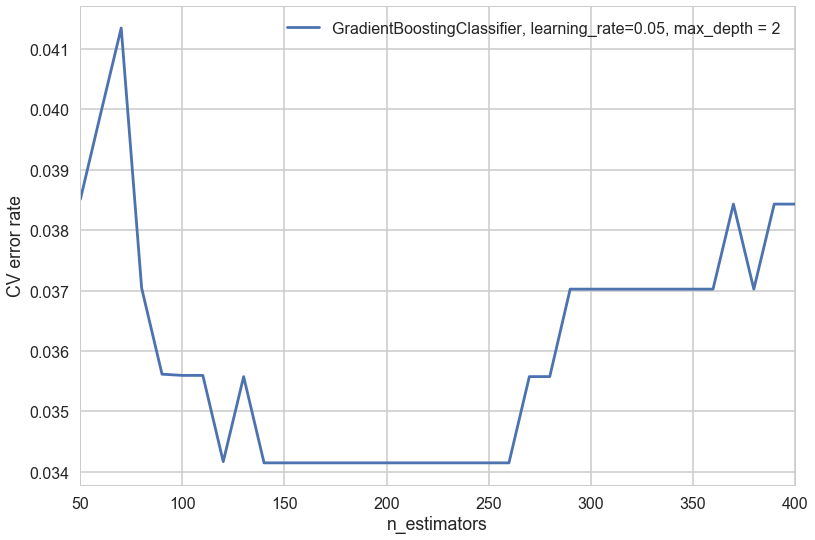

In [133]:
ensemble_clfs = [
    ("GradientBoostingClassifier, learning_rate=0.05, max_depth = 2",
        GradientBoostingClassifier(learning_rate = 0.05, max_depth = 2)),

#    ("GradientBoostingClassifier, learning_rate=0.02, max_depth = 2",
#        GradientBoostingClassifier(learning_rate = 0.02, max_depth = 2)),

#    ("GradientBoostingClassifier, learning_rate=0.005, max_depth = 2",
#        GradientBoostingClassifier(learning_rate = 0.005, max_depth = 2)),
#    ("GradientBoostingClassifier, learning_rate=0.001, max_depth = 3",
#        GradientBoostingClassifier(learning_rate = 0.001, max_depth = 3)),
#    ("GradientBoostingClassifier, learning_rate=0.001, max_depth = 2",
#        GradientBoostingClassifier(learning_rate = 0.001, max_depth = 2)),
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 50
max_estimators = 400
interval_estimators = 10

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1,interval_estimators):
        clf.set_params(n_estimators=i)
        clf.fit(df_resamp, outcome_resamp)

        # Record the CV accuracy for each `n_estimators=i` setting.
        score = cross_val_score(clf, df_resamp, outcome_resamp, scoring="accuracy", cv=10, n_jobs  = 3)
        CV_error = 1 - np.mean(score)
        error_rate[label].append((i, CV_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("CV error rate")
plt.legend(loc="upper right")
plt.show()

In [129]:
# retrain from the best CV'ed model
gbm = GradientBoostingClassifier(n_estimators = 200, learning_rate = 0.05, max_depth = 2)
gbm.fit(df_resamp, outcome_resamp)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [130]:
importance = gbm.feature_importances_
importance = pd.DataFrame(importance, index=df_resamp.columns, columns=["Importance"])
importance = importance.sort_values(by="Importance", ascending = False)
importance

,Importance
cellsize_uniformity,0.188337
clumpthick,0.154827
nuclei,0.153787
epi_cellsize,0.107835
nucleoli,0.102772
chromatin,0.089978
adhesion,0.085587
cellshape_uniformity,0.067888
mitoses,0.048990
